# Leverging Simulations from Bootstrap Sampling to Optimize QB Drafting Strategy

@thoov08 on [Twitter](https://twitter.com/thoov08) and [GitHub](https://github.com/thoov08)

In [2]:
import pandas as pd
import numpy as np
import pyarrow
import nfl_data_py as nfl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from pygam import LinearGAM
import time

In [5]:
# read in data from BBM3 drafts
bbm3=[]
for i in range(9):
    print("reading files from group " + str(i))
    try:
        bbm3.append(pd.read_csv("https://raw.githubusercontent.com/fantasydatapros/best-ball-data-bowl/master/data/2022/regular_season/fast/part_0" + str(i+1) + ".csv"))
        time.sleep(1)
    except:
        print("failed fast " + str(i))
        pass
    try:
        bbm3.append(pd.read_csv("https://raw.githubusercontent.com/fantasydatapros/best-ball-data-bowl/master/data/2022/regular_season/mixed/part_0" + str(i+1) + ".csv"))
        time.sleep(1)
    except:
        print("failed mixed " + str(i))
        pass

for j in range(9,27):
    print("reading files from group " + str(j))
    try:
        if j < 10:
            fnum = "0" + str(j)
        else:
            fnum = str(j)
        bbm3.append(pd.read_csv("https://raw.githubusercontent.com/fantasydatapros/best-ball-data-bowl/master/data/2022/regular_season/fast/part_" + fnum + ".csv"))
        time.sleep(1)
    except:
        print("failed fast " + str(j))
        pass
    
bbm3 = pd.concat(bbm3)

# keep data only for draft_id values with 216 picks (data might be spread across other files not used here or missing entirely)
draft_ids_to_keep = bbm3['draft_id'].value_counts()
draft_ids_to_keep = draft_ids_to_keep[draft_ids_to_keep == 216].index.values
bbm3 = bbm3[bbm2['draft_id'].isin(draft_ids_to_keep)]

# replace FB position with RB
bbm2['position_name'] = np.where(bbm3['position_name']=="FB", "RB", bbm3['position_name'])

# join in draft capital spent on each pick
draft_capital = pd.read_csv("https://raw.githubusercontent.com/thoov08/best_ball_data_bowl_2023_submission/main/bbm_draft_capital.csv")
bbm3 = bbm3.merge(draft_capital, how='left', left_on='overall_pick_number', right_on='pick')

# join in team level sim data (explained later)
bbm3_sim = pd.read_parquet("https://github.com/thoov08/best_ball_data_bowl_2023_submission/raw/main/bbm3_team_sims.parquet")
bbm3 = bbm3.merge(bbm3_sim, how='left', on='tournament_entry_id')

print("*** complete ***")

reading files from group 0
reading files from group 1
reading files from group 2
reading files from group 3
reading files from group 4
reading files from group 5
reading files from group 6
reading files from group 7
reading files from group 8
failed mixed 8
reading files from group 9
reading files from group 10
reading files from group 11
reading files from group 12
reading files from group 13
reading files from group 14
reading files from group 15
reading files from group 16
reading files from group 17
reading files from group 18
reading files from group 19
reading files from group 20
reading files from group 21
reading files from group 22
reading files from group 23
reading files from group 24
reading files from group 25
reading files from group 26
*** complete ***


In [6]:
# get number of picks each team made at each position
bbm3_team_n_picks_by_pos = bbm3.pivot_table(index="tournament_entry_id", columns="position_name", values="draft_capital_value", aggfunc='count', fill_value=0).reset_index()
bbm3_team_n_picks_by_pos.columns=['tournament_entry_id','n_picked_QB','n_picked_RB','n_picked_TE','n_picked_WR']

# get draft capital spent by each team
bbm3_team_dc_by_pos = bbm3.pivot_table(index="tournament_entry_id", columns="position_name", values="draft_capital_value", aggfunc='sum').reset_index()
bbm3_team_dc_by_pos.columns=['tournament_entry_id','dc_spent_QB','dc_spent_RB','dc_spent_TE','dc_spent_WR']

# combine into single data frame
bbm3_rosters = bbm3[['draft_id','tournament_entry_id','adv_to_qtr','adv_in_sim']].drop_duplicates() \
    .merge(bbm3_team_n_picks_by_pos, how='left', on='tournament_entry_id') \
    .merge(bbm3_team_dc_by_pos, how='left', on='tournament_entry_id')

# determine percentile of draft capital spent at each position
# will be slightly different than ETR draft capital since we're using only a portion of all BBM3 drafts
def get_percentile(value):
    return pd.qcut(-value, q=100, labels=False) + 1

# add columns for each position
for pos in ['QB','RB','TE','WR']:
    bbm3_rosters[pos + '_pctl'] = get_percentile(bbm3_rosters['dc_spent_' + pos])

### Introduction

Determining how many players of each position group to draft and in which rounds to draft them is a critical strategic element to best ball fantasy football drafts. Many drafters use rule-based strategies, such as Zero RB, to build rosters with historically strong results. One problem with this is the historical data can be noisy due to the small number of NFL seasons with a large volume of best ball draft data available. Building analyses and models solely from this historical data can often lead drafters to make decisions based on strategies that have worked well in the prior year instead of basing decisions on the full distribution of outcomes.


### Why historical advance rates are misleading

Descriptive analysis, statistical modeling, and machine learning approaches to answer the questions “which round should I draft each position group?” based on BBM3 data are likely to suggest drafters should be selecting:

* Elite TE in the late 1st or early 2nd round
* QB with rushing upside in the 5th round
* RB with high redzone upside in the 6th round

This strategy was excellent in BBM3 because picking these positions in those rounds likely would have led to Travis Kelce, Jalen Hurts, and Josh Jacobs. Each of these players had advance rates of at least 30% because they had breakout years. For Kelce and Jacobs, it also helped that several other top players from their position group underperformed their preseason expectations and hurt other teams drafting these players. Models built solely on this historical data could be heavily biased towards 2022 NFL season outcome if steps are taken to avoid this problem.

In [7]:
# find players with highest advance rates from our BBM3 files
# note: these rates will be slightly different than overall since we're only using a sample of all drafts
bbm3_actual_team_scores = bbm3[['draft_id','tournament_entry_id','roster_points']].drop_duplicates().reset_index(drop=True)
teams_advanced = bbm3_actual_team_scores.groupby('draft_id')['roster_points'].nlargest(2).index
teams_advanced_ids = bbm3_actual_team_scores.loc[teams_advanced.get_level_values(1), 'tournament_entry_id'].tolist()

bbm3['adv_to_qtr'] = bbm3['tournament_entry_id'].isin(teams_advanced_ids)

# only counting players drafted at least 1,000 times
actual_player_advance_rates = bbm3.groupby(['position_name','player_name'])['adv_to_qtr'].agg(['size','mean']).reset_index()
actual_player_advance_rates = actual_player_advance_rates[actual_player_advance_rates['size'] >= 1000].sort_values('mean', ascending=False).rename(columns={'mean':'adv_rate'})

#### *Which players had the best quarterfinals advance rates in BBM3?*

*(players drafted 1,000+ times in sample)*

In [9]:
actual_player_advance_rates.head(10)

,position_name,player_name,size,adv_rate
187,RB,Josh Jacobs,33014,0.462895
657,WR,Tyreek Hill,33014,0.355607
254,RB,Tony Pollard,33014,0.346792
30,QB,Jalen Hurts,33014,0.338432
222,RB,Miles Sanders,33014,0.325468
163,RB,Jamaal Williams,32862,0.310693
67,QB,Patrick Mahomes,33014,0.304568
384,TE,Travis Kelce,33014,0.302387
405,WR,Amon-Ra St. Brown,33014,0.285818
654,WR,Tyler Lockett,33014,0.280639


Applying these same approaches the following year is unlikely to give drafters the same edge. Based on current ADP as of July 30, Dameon Pierce and David Montgomery are being drafted around the same point in drafts as Josh Jacobs was in BBM3. It’s very unlikely that either of these players will have an advance rate in BBM4 anywhere close to the 47% advance rate teams drafting Jacobs had in BBM3.

### How can the bias on historical results be reduced?

We would ideally build analyses and models to determine optimal positional draft allocation based on the full distribution of player outcomes. This isn’t easy with small sample sizes. The obvious solution is to collect more data. Unfortunately, we don’t have years and years of BBM draft data available for past NFL seasons. Another option is to use bootstrap sampling to estimate the distribution of outcomes. Bootstrap sampling randomly selects a single historical data point, adds it to our distribution, and repeats until enough samples are taken to build a distribution that approximates the actual range of outcomes.

Here we use bootstrap sampling on a group of similar players based on ADP within a position group to estimate a full BBM roster’s regular season score distribution. This approach effectively increases the sample size of data available to analyze by many multiples using the following steps:


* Step 1 - Develop pools of similar players
    - Identify a player which we want to estimate the distribution of possible fantasy points scored for each week of the BBM3 regular season
    - Find which eight players in the same position group had the closest ADP to the player being estimated. This is our “similar player pool”. One of the eight players would be the player being estimated.
    - Repeat these steps for each player on the roster until each of the 18 players have their own pool of eight similar players.
* Step 2 - Estimate a regular season score from the roster
    - Begin the bootstrap sampling by randomly selecting a single player from each of the similar player pools to develop a roster of similar players.
    - For each week in the regular season, take each individual player's weekly scores for that week, determine which scores would count towards the team total for each position, and sum the total to get a single regular season total score.
* Step 3 - Extend this approach across all 12 teams in a draft to simulate which teams advance

In [8]:
# read in weekly player stats and add UD fantasy points column
nfl_weekly_2022 = nfl.import_weekly_data(years=[2022])
nfl_weekly_2022['fpts'] = nfl_weekly_2022.apply(lambda row: row['receptions']*0.5 + row['receiving_tds']*6.0 + row['receiving_yards']*0.1 + row['rushing_tds']*6.0 + row['rushing_yards']*0.1 + row['passing_yards']*0.04 + row['passing_tds']*4.0 + row['interceptions']*-1.0 + row['passing_2pt_conversions']*2.0 + row['rushing_2pt_conversions']*2.0 + row['receiving_2pt_conversions']*2.0 + row['sack_fumbles_lost']*-2.0 + row['rushing_fumbles_lost']*-2.0 + row['receiving_fumbles_lost']*-2.0, axis=1)

# fix a few name mismatches between BBM files and weekly stats
nfl_weekly_2022.loc[nfl_weekly_2022['player_display_name'] == "DJ Moore", 'player_display_name'] = 'D.J. Moore'
nfl_weekly_2022.loc[nfl_weekly_2022['player_display_name'] == "AJ Dillon", 'player_display_name'] = 'A.J. Dillon'
nfl_weekly_2022.loc[nfl_weekly_2022['player_display_name'] == "Joshua Palmer", 'player_display_name'] = 'Josh Palmer'
nfl_weekly_2022.loc[nfl_weekly_2022['player_display_name'] == "DJ Chark", 'player_display_name'] = 'D.J. Chark'
nfl_weekly_2022.loc[nfl_weekly_2022['player_display_name'] == "KJ Hamler", 'player_display_name'] = 'K.J. Hamler'
nfl_weekly_2022.loc[nfl_weekly_2022['player_display_name'] == "Robbie Anderson", 'player_display_name'] = 'Robbie Anderson'
nfl_weekly_2022.loc[nfl_weekly_2022['player_display_name'] == "Jeff Wilson", 'player_display_name'] = 'Jeff Wilson'
nfl_weekly_2022.loc[nfl_weekly_2022['player_display_name'] == "Mike Davis", 'player_display_name'] = 'Mike Davis'
# some other names in BBM files aren't found in nfl weekly data, but those players didn't play and had no weekly stats

Downcasting floats.


In [10]:
# calculate ADP for each player

# only keep players drafted 20+ times (ex. Davis Webb was drafted just once and it was at 1.06)
players_to_keep = bbm3['player_name'][bbm3['player_name'].map(bbm3['player_name'].value_counts()) >= 20]

bbm3_adp = bbm3[bbm3['player_name'].isin(players_to_keep)]\
    .groupby(['player_name','position_name'])['overall_pick_number'].mean().reset_index()\
    .sort_values(['position_name','overall_pick_number'])\
    .rename(columns={'overall_pick_number': 'adp'})\
    .reset_index(drop=True)

In [11]:
### functions for similar player bootstramp sampling simulation

# create function to return player names of most similar players by ADP
def get_similar_players_for_lineup(players, positions, n_similar_players=8):
    # if player not found in ADP, replace ADP with 215
    output=[]
    for i in range(len(players)):
        same_pos_adp = bbm3_adp.loc[bbm3_adp['position_name'] == positions[i],:]
        adp_of_player = bbm3_adp.loc[bbm3_adp['player_name'] == players[i], 'adp'].values
        if len(adp_of_player) == 0:
            adp_of_player = np.array(215)
        same_pos_adp = same_pos_adp.assign(dist = np.abs(same_pos_adp['adp'].values - adp_of_player))
        output.append(np.random.choice(same_pos_adp['player_name'][same_pos_adp.nsmallest(n_similar_players, 'dist').index].values))
    return output

# create function to take weekly fpts scored for each player, determine which scores count, then sum to team's total score for the week
def get_roster_fpts_for_week(week_player_pts_df):
    idx_QB = week_player_pts_df[(week_player_pts_df['position_group'] == "QB")].sort_values('fpts', ascending=False).head(1).index.values
    idx_RB = week_player_pts_df[(week_player_pts_df['position_group'] == "RB")].sort_values('fpts', ascending=False).head(2).index.values
    idx_WR = week_player_pts_df[(week_player_pts_df['position_group'] == "WR")].sort_values('fpts', ascending=False).head(3).index.values
    idx_TE = week_player_pts_df[(week_player_pts_df['position_group'] == "TE")].sort_values('fpts', ascending=False).head(1).index.values
    idx_FLEX = week_player_pts_df[(week_player_pts_df['position_group'] != "QB") & (~week_player_pts_df.index.isin(idx_RB)) & (~week_player_pts_df.index.isin(idx_WR)) & (~week_player_pts_df.index.isin(idx_TE))].sort_values('fpts', ascending=False).head(1).index.values
    return np.sum(week_player_pts_df.loc[np.concatenate([idx_QB, idx_RB, idx_WR, idx_TE, idx_FLEX]),'fpts'].values)

# create function to take a lineup ID, simulate a group of similar players from their roster, then calculate what the team's weekly scores would've been for the similar roster
def sim_entry_on_similar_players(entry_to_use):
    entry_actual_players = bbm3[bbm3['tournament_entry_id'] == entry_to_use]['player_name'].values
    entry_actual_positions = bbm3[bbm3['tournament_entry_id'] == entry_to_use]['position_name'].values
    players_for_sim = get_similar_players_for_lineup(entry_actual_players, entry_actual_positions)
    weekly_outcomes = nfl_weekly_2022[(nfl_weekly_2022['player_display_name'].isin(players_for_sim)) & (nfl_weekly_2022['week'] <= 14)][['week','position_group','fpts']]
    weekly_outcomes.loc[weekly_outcomes['position_group'] == "FB", "position_group"] = 'RB'
    weekly_roster_score = []
    for i in range(14):
        weekly_roster_score.append(get_roster_fpts_for_week(weekly_outcomes[weekly_outcomes['week']==i+1]))
    return weekly_roster_score

# simulate the full season score for a simulated lineup a given number of times
def sim_total_reg_season_roster_score(entry_to_use, n_sims=50):
    simmed_weekly_scores=[]
    for sim_idx in range(n_sims):
        simmed_weekly_scores.append(sim_entry_on_similar_players(entry_to_use))
    return np.sum(np.array(simmed_weekly_scores), axis=1)

In [12]:
example_player = 'Josh Jacobs'
example_position = 'RB'
n_similar_players = 8

same_pos_adp = bbm3_adp.loc[bbm3_adp['position_name'] == example_position,:]
adp_of_player = bbm3_adp.loc[bbm3_adp['player_name'] == example_player, 'adp'].values
same_pos_adp = same_pos_adp.assign(dist = np.abs(same_pos_adp['adp'].values - adp_of_player))
example_similar_players = same_pos_adp['player_name'][same_pos_adp.nsmallest(n_similar_players, 'dist').index].values
print(example_similar_players)

['Josh Jacobs' 'Elijah Mitchell' 'AJ Dillon' 'Antonio Gibson'
 'Tony Pollard' 'J.K. Dobbins' 'David Montgomery' 'Clyde Edwards-Helaire']


In [13]:
nfl_weekly_2022[['player_display_name','week','fpts']][(nfl_weekly_2022['player_display_name']=='Josh Jacobs') & (nfl_weekly_2022['week'] <= 14)]['fpts'].values

array([ 7.8,  8.6, 12.2, 32. , 27.8, 35. ,  6.4, 10.2, 19.6, 17.5, 45.3,
       20. , 18.4])

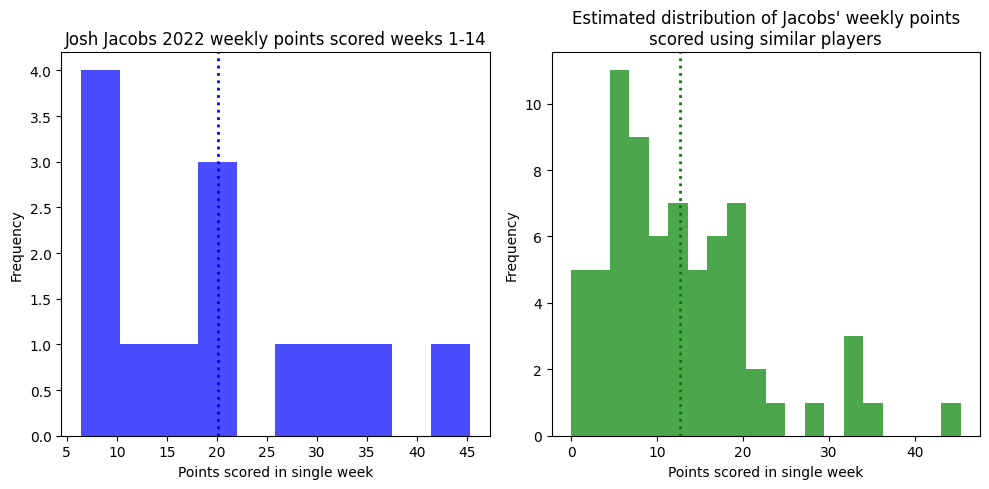

In [14]:
example_player_scores = nfl_weekly_2022[['player_display_name','week','fpts']][(nfl_weekly_2022['player_display_name']==example_player) & (nfl_weekly_2022['week'] <= 14)]['fpts'].values
similar_player_scores = nfl_weekly_2022[['player_display_name','week','fpts']][(nfl_weekly_2022['player_display_name'].isin(example_similar_players)) & (nfl_weekly_2022['week'] <= 14)]['fpts'].values

# Create a figure with two subplots arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first histogram in the first subplot
ax1.hist(example_player_scores, color='blue', alpha=0.7)
ax1.set_title('Josh Jacobs 2022 weekly points scored weeks 1-14')
ax1.set_xlabel('Points scored in single week')
ax1.set_ylabel('Frequency')
ax1.axvline(x=np.mean(example_player_scores), linestyle='dotted', linewidth=2, color='blue')

# Plot the second histogram in the second subplot
ax2.hist(similar_player_scores, bins=20, color='green', alpha=0.7)
ax2.set_title("Estimated distribution of Jacobs' weekly points\nscored using similar players")
ax2.set_xlabel('Points scored in single week')
ax2.set_ylabel('Frequency')
ax2.axvline(x=np.mean(similar_player_scores), linestyle='dotted', linewidth=2, color='green')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show();

The benefit of this approach is that it greatly reduces bias caused by analyses pushing players towards strategies with high historical advance rates. For example, a team drafting Josh Jacobs in BBM3 would have some simulations based on Jacobs’ strong season, but would also simulate from the pool of other RBs with similar ADP in BBM3 with weaker results such as AJ Dillon, Antonio Gibson, and Clyde Edwards-Helaire.

This approach is not perfect. The pool of eight similar players may include players of different archetypes. It also limits the upside from the top end of their position group as they are sampling from worse players. This approach takes the stance that the benefit of reducing the bias from a single player’s outcome outweighs the downside of adding variance from a larger pool of players. Further work could be done here to refine the approach and improve the precision of the estimated distribution of outcomes.

### What do we learn using the simulation approach?

The table below shows the actual and simulated advance rates for the top 10 advance rate players in BBM3. Simulated advance rates are much lower because they are less influenced by the specific player's strong year in 2022. Instead, the simulated advance rates help to assess if selecting a player from that particular position group in the same ADP range was a successful strategy.

In [139]:
# Top 10 actual adv rate players - compare to their simmed advance rates from simulated outcomes for each team in the files we’re using

adv_rates = bbm3.merge(bbm3_adp, how='left', on=['player_name','position_name'])\
    .groupby(['position_name','player_name','adp'])[['adv_to_qtr','adv_in_sim']]\
    .mean()\
    .rename(columns={'adv_to_qtr':'Actual advance rate', 'adv_in_sim':'Simmed advance rate'})\
    .reset_index()
player_freq_in_data = bbm3['player_name'].value_counts()
players_over_1k_freq = player_freq_in_data[player_freq_in_data >= 1000].index
top_actual_adv_rates = actual_player_advance_rates['player_name'][:10]

adv_rates['adp'] = adv_rates['adp'].round(1)
adv_rates['Actual advance rate'] = adv_rates['Actual advance rate'].round(3)
adv_rates['Simmed advance rate'] = adv_rates['Simmed advance rate'].round(3)
adv_rates[adv_rates['player_name'].isin(top_actual_adv_rates)].sort_values('Actual advance rate', ascending=False).head(10)



,position_name,player_name,adp,Actual advance rate,Simmed advance rate
110,RB,Josh Jacobs,71.4,0.463,0.195
395,WR,Tyreek Hill,21.7,0.356,0.183
152,RB,Tony Pollard,82.8,0.347,0.212
13,QB,Jalen Hurts,61.1,0.338,0.182
134,RB,Miles Sanders,88.6,0.325,0.204
97,RB,Jamaal Williams,167.5,0.311,0.185
33,QB,Patrick Mahomes,47.1,0.305,0.187
220,TE,Travis Kelce,12.4,0.302,0.115
233,WR,Amon-Ra St. Brown,58.3,0.286,0.147
393,WR,Tyler Lockett,98.4,0.281,0.156


Even though the simulated advance rates are lower than actuals, many of these players still have simulated outcomes above the 16.7% average advance rate, which suggest these players were still good picks at ADP in BBM3. One notable exception is Travis Kelce with an estimated 11.5% advance rate. Kelce's sampled distribution of outcomes includes his own strong performances in 2022, but also includes disappointing results from injured Mark Andrews and low pass game volume from Kyle Pitts. It is reasonable that 2023 Travis Kelce could also disappoint due to injury or loss of target share due to the emergence of their young receivers.

*(placeholder to call out best players based on simmed results)*




OLD
Callout these groups:
- early WR (Deebo ADP 19, Diggs ADP 9, CeeDee ADP 14)
- mid-round RBs (Gibson ADP 83, Pollard ADP 83, Sanders ADP 91, Mitchell ADP 67)
- Tier 2 QBs (Lamar ADP 48, Herbert ADP 44)
- no TE (compared to Kelce in actual - Everett does show up as #8, but no other TEs until Evan Engram at #23)

The table below shows the top players based on *simulated* advance rates. These represent the best positional picks at ADP based on their distribution of outcomes.

In [143]:
# Top 10 simmed adv rate players - show actual and simmed - add commentary about what these results say about build types
top_simmed_adv_rates = adv_rates[adv_rates['player_name'].isin(players_over_1k_freq)].sort_values('Simmed advance rate', ascending=False)
top_simmed_adv_rates.head(10)

,position_name,player_name,adp,Actual advance rate,Simmed advance rate
279,WR,Deebo Samuel,18.7,0.117,0.235
52,RB,Antonio Gibson,81.2,0.175,0.216
152,RB,Tony Pollard,82.8,0.347,0.212
21,QB,Justin Herbert,43.9,0.121,0.211
250,WR,CeeDee Lamb,14.1,0.158,0.206
377,WR,Stefon Diggs,8.6,0.255,0.204
134,RB,Miles Sanders,88.6,0.325,0.204
25,QB,Lamar Jackson,48.0,0.167,0.203
298,WR,Ja'Marr Chase,5.4,0.129,0.196
186,TE,Gerald Everett,161.9,0.166,0.195


These results highlight a few different strategies to improve advance rates:

- Drafting early round WRs (Diggs at ADP 9, Lamb at ADP 14, and Samuel at ADP 19 are all in top 10)
- Drafting RBs around rounds 7-8 (Gibson at ADP 81, Pollard at ADP 83, Sanders at ADP 89 all in top 10)
- Drafting "Tier 2" QBs (Herbert at ADP 44 and Jackson at ADP 48 all in top 10)

One interesting note is that no specific strategy for TE sticks out. Gerald Everett cracked the top 10 players in simulated advance rate, but not many other TEs showed significant improvement in simulated advance rates over others. This was true across all ADP ranges. Optimizing draft strategy for TEs is not likely to have the same level of impact as optimizing draft strategy at other positions.

This approach allows for deeper experimentation and research not feasible from using a traditional approach purely on 1-2 years of actual historical data. A few of these areas could be:
Improved estimation on advance rate of different build types
Understanding tradeoffs of optimizing for regular season score vs single-week playoff success
Using reinforcement learning techniques, such as Monte Carlo Tree Search, to build AI models optimizing which position to draft based on players already taken and expected picks from opponents

This analysis opts to use a simplified approach to help answer the question of how much draft capital should drafters spend at each position? This is done by combining the simulation approach described above with ADP draft capital values from [Mike Leone’s Best Ball Manifesto article on Establish the Run](https://establishtherun.com/best-ball-mania-manifesto-a-guide-to-winning-big-on-underdog-fantasy/).


### How can we use this simulation approach to optimize our draft strategy at different positions?

To understand optimal draft capital to spend at each position, we create a GAM model for each position group to smooth out the relationship between draft capital spent at each position compared to simulated advance rate outcomes.


In [117]:
def create_plot_for_optimal_position_draft_capital(position):
    col_name= 'dc_spent_' + position
    if position=='QB':
        color='purple'
    elif position=='RB':
        color='green'
    elif position=='WR':
        color='orange'
    else:
        color='blue'

    gam = LinearGAM().fit(bbm3_rosters[col_name], bbm3_rosters['adv_in_sim'])
    x_vals = np.linspace(min(bbm3_rosters[col_name]), max(bbm3_rosters[col_name]), 100)
    y_vals = gam.predict(x_vals)

    

    # Joint plot with scatter plot and marginal histograms
    p01 = np.quantile(bbm3_rosters[col_name], 0.01)
    p99 = np.quantile(bbm3_rosters[col_name], 0.99)
    sns.jointplot(data=bbm3_rosters, x=col_name, y='adv_in_sim', kind='scatter', color='white',
                  marginal_kws={'color':color},
                  height=6, ratio=3, space=0)
    plt.plot(x_vals, y_vals, label='GAM estimate', color=color, linewidth=2)
    plt.xlabel(position + ' draft capital spent')
    plt.ylabel('Estimated advance rate')
    plt.suptitle(position)
    plt.xlim(p01, p99)
    plt.ylim(0,0.25)
    plt.axhline(y=2/12, linestyle="dotted", color="gray", linewidth=2)
    plt.show()

The histogram bar plot on the top of the chart represents the frequency of BBM3 entries spending that amount of draft capital in the given position group. BBM3 entries averaged QB draft capital spend somewhere between 80-100, but it was not uncommon for teams to stray from that range in either direction.

Results here suggest that the range of 90-115 is optimal for QB draft capital spend. This is equivalent to taking an elite QB in the 3rd round and a second QB in the 12 round (though there are many other combinations of draft picks to get in this range). Drafters should be outspending the field in the QB position until extreme high draft capital value of 160.

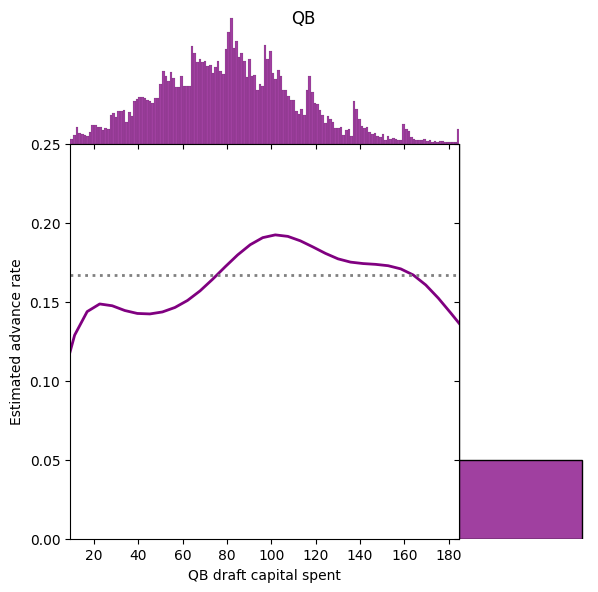

In [123]:
create_plot_for_optimal_position_draft_capital("QB")

The BBM3 field dramatically overspent draft capital at the RB position. Teams spending below the average RB draft capital of 270 had a much higher estimated advance rate than RB-heavy teams. This is not surprising and has been well-documented in other research across the industry. BBM4 ADP already reflects a major shift in early round pick preference away from RB towards WR. The market would need to have an enormous shift in BBM4 for underspending the field at RB not be an expected +EV strategy.

One interesting note is that the estimated advance rates never dip significantly below average even for teams pushing off drafting RBs to extreme ends of the draft. Fewer than 5% of BBM3 entries spent less than 150 draft capital at RB. Their estimated advance rates did not drop until near the 100 draft capital mark which <1% of entries stayed under. Not only are many drafters overspending at RB, but most educated drafters who already put off drafting RBs should be pushing this edge even more by waiting longer and/or drafting fewer RBs.

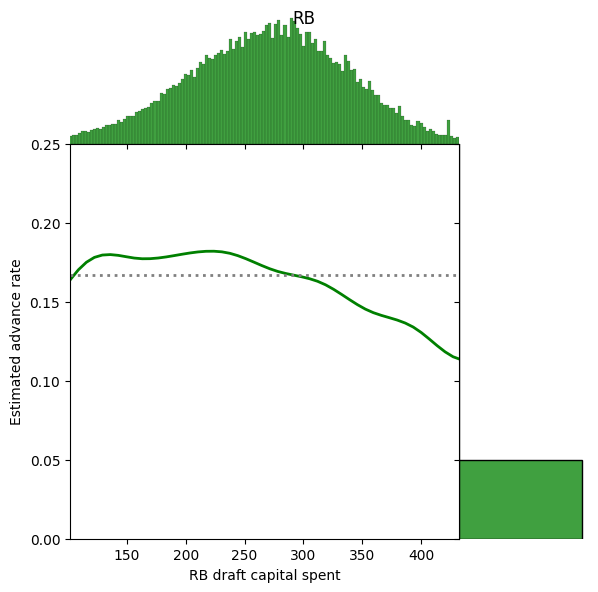

In [124]:
create_plot_for_optimal_position_draft_capital("RB")

In [160]:
np.quantile(bbm3_rosters['dc_spent_WR'], 0.875)

450.63797121725

The BBM3 field did not spend enough at the WR position. Teams spending above average draft capital at the WR position had a higher estimated advance rate compared to other teams. Similar to the RB analysis above, this is another edge that even the strongest WR drafters can push further. The top 12.5% of teams spending over 450 draft capital at WR had an estimated advance rate just slightly below the optimal range of 420-430. There are no evidence that drafters are spending too much draft capital at the WR position causing their teams to be less probable to advance.

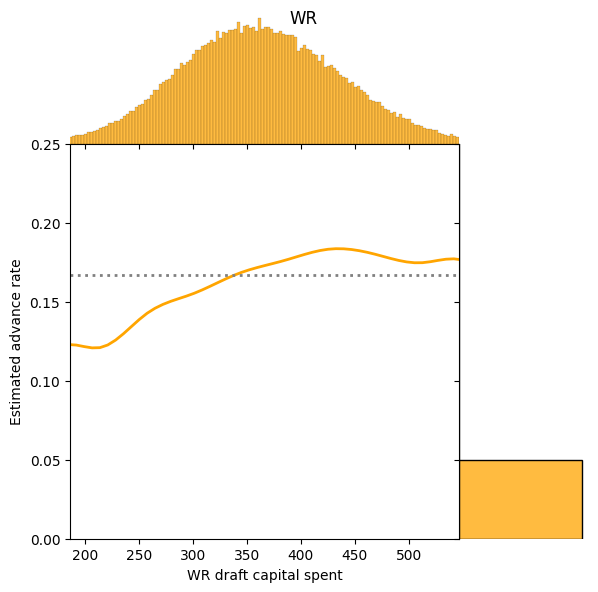

In [126]:
create_plot_for_optimal_position_draft_capital("WR")

The TE position does not give the same level of obvious insights as the other positions. The top end of most BBM3 entries capped their TE draft capital spend around 110. The small number of teams that exceeded this threshold overspent materially decreasing their probability to advance.

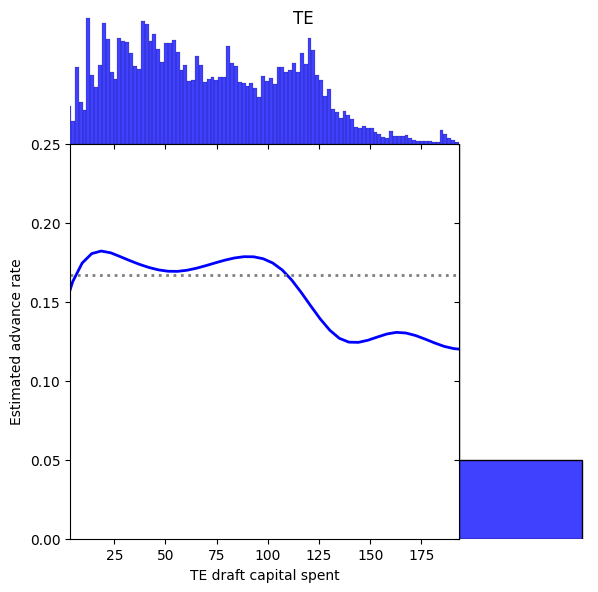

In [127]:
create_plot_for_optimal_position_draft_capital("TE")

It’s important to note that this approach optimizes for regular season advance rate. Drafters ideally would advance many teams with unique builds with stacks or game correlation needed to maximize the probability of winning the BBM4 playoffs. Because of this, drafters don’t need to be overly-focused on spending draft capital exactly in the top ranges of these models. Straying from those top ranges in order to draft players after ADP, filling out stacks, or adding game correlation is likely a good decision in some cases. These models have more value in quantifying how much advance rate is being sacrificed and avoiding significant mistakes.


### How much can we improve advance rate by using these strategies?

We can use estimated and actual advance rates of teams using these strategies compared to other teams who used suboptimal strategies. Based on the analysis above, a "strong" team is defined here as:

- Between 90-115 draft captial at QB
- Max of 275 draft captial at RB
- At least 350 draft capital at WR
- Max of 110 draft capital at TE

Only 7% of BBM3 entries meet all of these crtieria.

In [164]:
# compare good vs bad teams

bbm3_rosters['strategy_group'] = bbm3_rosters.apply(lambda row: (row['dc_spent_QB'] >= 90) & (row['dc_spent_QB'] <= 115) & (row['dc_spent_RB'] <= 275) & (row['dc_spent_WR'] >= 350) & (row['dc_spent_TE'] <= 110), axis=1)


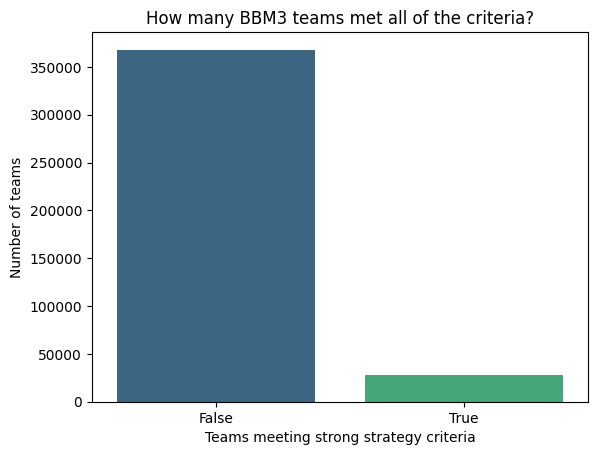

In [229]:
strategy_counts = bbm3_rosters['strategy_group'].value_counts()
sns.barplot(x=strategy_counts.index, y=strategy_counts.values, palette='viridis')
plt.title('How many BBM3 teams met all of the criteria?')
plt.xlabel("Teams meeting strong strategy criteria")
plt.ylabel("Number of teams")
plt.show();

The average advance rate of a BBM3 team is 16.7%. The teams with strong strategy blew past this with an excellent 22.9% advance rate. The simulations correctly estimated this group of teams to strongly outperform others.

In [232]:
bbm3_rosters.groupby('strategy_group')[['adv_to_qtr','adv_in_sim']].mean().rename(columns={'adv_to_qtr':'Actual advance rate','adv_in_sim':'Simmed advance rate'})

,Actual advance rate,Simmed advance rate
strategy_group,,
False,0.161873,0.162696
True,0.229058,0.218339


The same approach can be used to understand to take a more nuanced look into how roster construction impacts floor, median, and ceiling outcomes. The plot below takes a randomly selected "strong strategy" team and a randomly selected "other strategy" teams, simulates each of their total regular season roster scores 500 times, then compares the distributions. The team with the better strategy not only had a higher average outcome, but also more frequently had higher ceiling outcomes of 1,700+ points needed to advance to the playoffs and compete for the regular season prize pool.

In [217]:
# simulate a "strong strategy" team against a randomly selected non-strong team
# strong team advanced in sim but not actual, other team didn't advance in sim or actual

strong_team_sims = sim_total_reg_season_roster_score("ba793b99-6bc9-4fa3-b7a8-199e6f6c0615", n_sims=500)
other_team_sims = sim_total_reg_season_roster_score("09cadc69-f077-4446-9101-3e808a9379c4", n_sims=500)

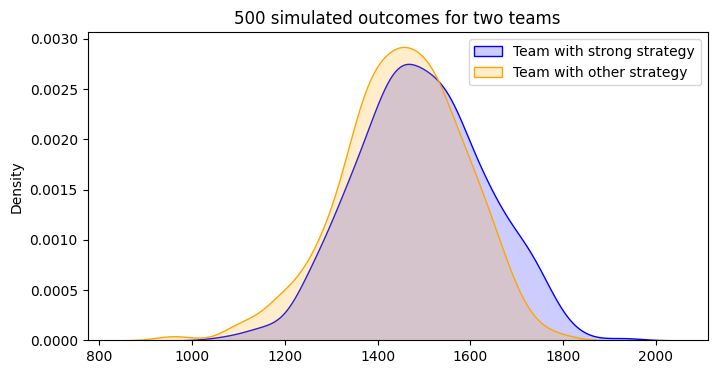

In [225]:
plt.figure(figsize=(8,4))
sns.kdeplot(strong_team_sims, color='blue', fill=True, alpha=0.2, label='Team with strong strategy')
sns.kdeplot(other_team_sims, color='orange', fill=True, alpha=0.2, label='Team with other strategy')
plt.legend(loc='upper right')
plt.title("500 simulated outcomes for two teams")
plt.plot();

### Conclusion

Analysis of positional draft capital allocation can be heavily biased based on which specific players outperformed expectations over a single year. The bootstrap sampling approach described here greatly reduces that bias to give insights that are more predictive of future season outcomes.

A basic analysis using simulations of these samples finds drafters should:
- Draft WRs early and often, likely even stronger than the current WR-heavy BBM4 ADP
- Pair early round QBs with a late QB to spend roughly 90-115 total draft capital on QB
- Be comfortable with extremely low draft capital spent at RB
- Be willing to forego these other recommendations in the event of players falling well below ADP, filling out stacks, or drafting playoff round correlations.